<a href="https://colab.research.google.com/github/NoahHertog/PRA3024/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<!-- TODO(b/319266067) remove temporary advert after a few weeks. -->
<div class="markdown-google-sans">
  <h2>(New) Try the Gemini API</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Talk_to_Gemini_with_Google%27s_Speech_to_Text_API.ipynb?utm_medium=link&utm_campaign=gemini">Talk to Gemini with the Speech-to-Text API</a></li>
  <li><a href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/python_quickstart.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API: Quickstart with Python</a></li>
  <li><a href="https://colab.research.google.com/notebooks/snippets/gemini.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API code sample</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
#print(keras.__version__)

2.15.0


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


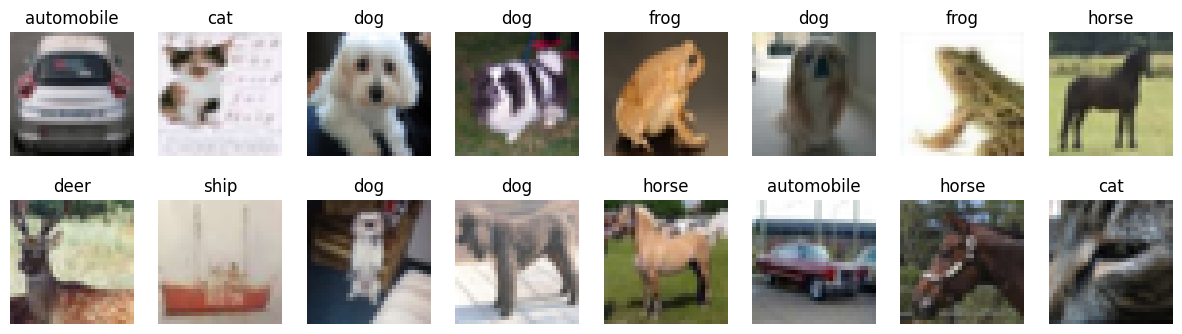

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [23]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization


In [72]:
def make_model():
  model = Sequential()

  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)))
  model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3,3), activation='sigmoid', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), activation='elu', padding='same'))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  return model

    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network.
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.
    ### END STUDENT CODE ###

    # Ensure normalized probabilities over the 10 classes
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    return lr * 0.95  # Adjust the factor as needed


In [73]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-4  # initial learning rate
BATCH_SIZE = 612
EPOCHS = 15



K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

#model.load_weights("weights.h5")

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer='adam',  # for SGD.
    metrics=['accuracy'] ) # report accuracy during training
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)


# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/15
66/66 [==============================] - 14s 132ms/step - loss: 1.8141 - accuracy: 0.4403 - val_loss: 4.6022 - val_accuracy: 0.0968
Epoch 2/15
66/66 [==============================] - 7s 103ms/step - loss: 1.1248 - accuracy: 0.6039 - val_loss: 4.1136 - val_accuracy: 0.0966
Epoch 3/15
66/66 [==============================] - 7s 104ms/step - loss: 1.0003 - accuracy: 0.6510 - val_loss: 3.7048 - val_accuracy: 0.0966
Epoch 4/15
66/66 [==============================] - 7s 105ms/step - loss: 0.9098 - accuracy: 0.6836 - val_loss: 3.3624 - val_accuracy: 0.1049
Epoch 5/15
66/66 [==============================] - 7s 110ms/step - loss: 0.8376 - accuracy: 0.7067 - val_loss: 2.5442 - val_accuracy: 0.1773
Epoch 6/15
66/66 [==============================] - 7s 107ms/step - loss: 0.7799 - accuracy: 0.7289 - val_loss: 1.5225 - val_accuracy: 0.4960
Epoch 7/15
66/66 [==============================] - 7s 107ms/step - loss: 0.7300 - accuracy: 0.7426 - val_loss: 1.2848 - val_accuracy: 0.5328
Epoch

In [70]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

313/313 [==============================] - 1s 3ms/step


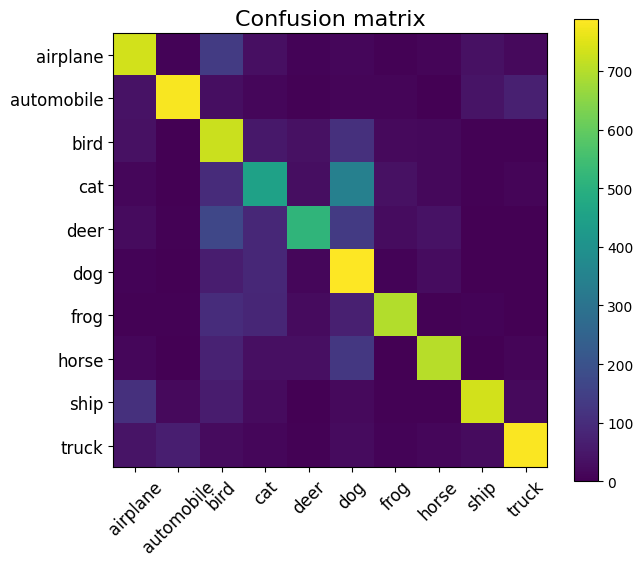

Test accuracy: 0.691


In [74]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

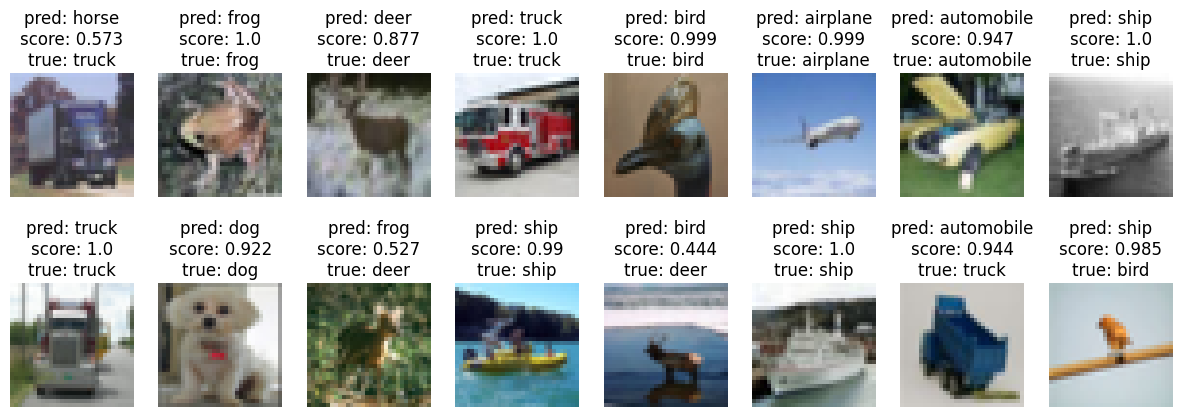

In [42]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view, and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  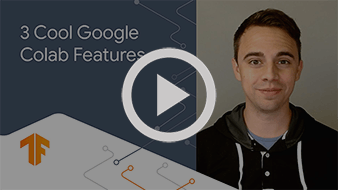
  </a>
</center>

<div class="markdown-google-sans">
  <h2>What is Colab?</h2>
</div>

Colab, or "Colaboratory", allows you to write and execute Python in your browser, with
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more, or just get started below!

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [12]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [13]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

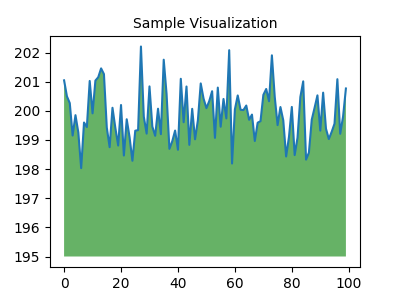

In [14]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb). Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [NeMo Voice Swap](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb): Use Nvidia's NeMo conversational AI Toolkit to swap a voice in an audio fragment with a computer generated one.

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.
